# visualize

> Generic spatial visualization: render any ee.Image, export PNGs, GIFs, and timestrips.
>
> This module is layer-agnostic. Dataset-specific helpers (Sentinel, MODIS, etc.) live in `gee_polygons.datasets`.

In [1]:
#| default_exp visualize

In [2]:
#| hide
from nbdev.showdoc import *

In [3]:
#| export
import ee
from PIL import Image, ImageDraw, ImageFont
from pathlib import Path
from typing import Optional, Union, Literal, Callable, TYPE_CHECKING
from dataclasses import dataclass
import io

if TYPE_CHECKING:
    from gee_polygons.layers import CategoricalLayer, ContinuousLayer
    from gee_polygons.site import Site

/Users/alice/.local/share/mamba/envs/gee-polygons/lib/python3.10/site-packages/google/api_core/_python_version_support.py:275: FutureWarning: You are using a Python version (3.10.19) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


## Visualization Parameters

A simple wrapper for GEE visualization parameters.

In [4]:
#| export
@dataclass
class VisParams:
    """Visualization parameters for rendering layers.
    
    Examples:
        # For single-band continuous data (NDVI, temperature)
        VisParams(min=-0.2, max=0.8, palette=['red', 'yellow', 'green'])
        
        # For RGB composites
        VisParams(min=0, max=0.3, bands=['B4', 'B3', 'B2'], gamma=1.4)
        
        # For categorical data
        VisParams(min=0, max=7, palette=['#111', '#ccc', '#0f0', ...])
    """
    min: Optional[float] = None
    max: Optional[float] = None
    palette: Optional[list[str]] = None
    bands: Optional[list[str]] = None
    gamma: Optional[float] = None
    
    def to_dict(self) -> dict:
        """Convert to GEE visualization params dict."""
        d = {}
        if self.min is not None:
            d['min'] = self.min
        if self.max is not None:
            d['max'] = self.max
        if self.palette is not None:
            d['palette'] = self.palette
        if self.bands is not None:
            d['bands'] = self.bands
        if self.gamma is not None:
            d['gamma'] = self.gamma
        return d

In [5]:
#| export
# Common visualization presets
NDVI_VIS = VisParams(
    min=-0.2, max=0.8,
    palette=['#d73027', '#f46d43', '#fdae61', '#fee08b', '#d9ef8b', '#a6d96a', '#66bd63', '#1a9850']
)

EVI_VIS = VisParams(
    min=0, max=0.6,
    palette=['#d73027', '#f46d43', '#fdae61', '#fee08b', '#d9ef8b', '#a6d96a', '#66bd63', '#1a9850']
)

## Core Rendering Functions

These are the building blocks - they work with any `ee.Image`.

In [6]:
#| export
def render_thumbnail(
    image: ee.Image,
    region: ee.Geometry,
    vis_params: dict,
    dimensions: int = 512,
    format: str = 'png'
) -> bytes:
    """Render an ee.Image to thumbnail bytes.
    
    Args:
        image: The image to render
        region: Region to render
        vis_params: Visualization parameters dict
        dimensions: Max dimension in pixels
        format: Image format ('png' or 'jpg')
        
    Returns:
        Image bytes
    """
    url = image.getThumbURL({
        'region': region,
        'dimensions': dimensions,
        'format': format,
        **vis_params
    })
    
    import urllib.request
    with urllib.request.urlopen(url) as response:
        return response.read()

In [7]:
#| export
def add_label(
    img: Image.Image,
    label: str,
    position: Literal['top-left', 'top-right', 'bottom-left', 'bottom-right'] = 'bottom-left',
    font_size: int = 16,
    text_color: str = 'white',
    bg_color: str = 'black',
    padding: int = 5
) -> Image.Image:
    """Add a text label to an image."""
    img = img.copy()
    draw = ImageDraw.Draw(img)
    
    try:
        font = ImageFont.truetype("/System/Library/Fonts/Helvetica.ttc", font_size)
    except:
        try:
            font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf", font_size)
        except:
            font = ImageFont.load_default()
    
    bbox = draw.textbbox((0, 0), label, font=font)
    text_width = bbox[2] - bbox[0]
    text_height = bbox[3] - bbox[1]
    
    x = padding if 'left' in position else img.width - text_width - padding * 2
    y = padding if 'top' in position else img.height - text_height - padding * 2
    
    if bg_color:
        draw.rectangle(
            [x - padding, y - padding, x + text_width + padding, y + text_height + padding],
            fill=bg_color
        )
    
    draw.text((x, y), label, fill=text_color, font=font)
    return img

In [8]:
#| export
def _parse_color(color: str) -> tuple[int, int, int]:
    """Parse hex color to RGB tuple."""
    if color.startswith('#'):
        return (
            int(color[1:3], 16),
            int(color[3:5], 16),
            int(color[5:7], 16)
        )
    return (255, 255, 255)


def _to_pil(thumb_bytes: bytes) -> Image.Image:
    """Convert thumbnail bytes to RGB PIL Image."""
    img = Image.open(io.BytesIO(thumb_bytes))
    if img.mode == 'RGBA':
        background = Image.new('RGB', img.size, (0, 0, 0))
        background.paste(img, mask=img.split()[3])
        return background
    elif img.mode != 'RGB':
        return img.convert('RGB')
    return img

## Generic Image Rendering

The core `render_image` function works with **any** `ee.Image`.

In [9]:
#| export
def render_image(
    image: ee.Image,
    region: ee.Geometry,
    vis_params: Union[VisParams, dict],
    dimensions: int = 512,
    boundary: Optional[ee.Geometry] = None,
    boundary_color: str = '#FFFFFF',
    boundary_width: int = 2,
    label: Optional[str] = None,
    label_position: str = 'bottom-left'
) -> Image.Image:
    """Render any ee.Image to a PIL Image.
    
    This is the core generic rendering function. It works with any ee.Image
    from any source (Sentinel, MODIS, Landsat, custom computations, etc.).
    
    Args:
        image: Any ee.Image to visualize
        region: Region to render (usually site.geometry.buffer(n).bounds())
        vis_params: Visualization parameters (VisParams or dict)
        dimensions: Image size in pixels
        boundary: Optional geometry to overlay as boundary line
        boundary_color: Color for boundary line
        boundary_width: Width of boundary line
        label: Optional text label
        label_position: Position for label
        
    Returns:
        PIL Image
        
    Example:
        # Get any ee.Image from any source
        image = ee.Image('USGS/SRTMGL1_003')  # elevation
        
        # Render it
        pil_img = render_image(
            image=image,
            region=site.geometry.buffer(1000).bounds(),
            vis_params={'min': 0, 'max': 3000, 'palette': ['green', 'yellow', 'brown']},
            boundary=site.geometry,
            label='Elevation'
        )
    """
    vis_dict = vis_params.to_dict() if isinstance(vis_params, VisParams) else vis_params
    
    if boundary is not None:
        # Create boundary overlay
        boundary_img = ee.Image().paint(
            featureCollection=ee.FeatureCollection([ee.Feature(boundary)]),
            color=1,
            width=boundary_width
        )
        
        # Visualize base image
        vis_img = image.visualize(**vis_dict)
        
        # Blend boundary
        r, g, b = _parse_color(boundary_color)
        boundary_vis = boundary_img.visualize(palette=[f'{r:02x}{g:02x}{b:02x}'])
        combined = vis_img.blend(boundary_vis.updateMask(boundary_img))
        
        thumb_bytes = render_thumbnail(combined, region, {}, dimensions)
    else:
        thumb_bytes = render_thumbnail(image, region, vis_dict, dimensions)
    
    pil_img = _to_pil(thumb_bytes)
    
    if label:
        pil_img = add_label(pil_img, label, position=label_position)
    
    return pil_img

## Layer-Based Rendering

Convenience functions for rendering `CategoricalLayer` and `ContinuousLayer` objects.

In [10]:
#| export
def get_vis_params_from_layer(layer: 'CategoricalLayer') -> dict:
    """Extract visualization params from a CategoricalLayer's palette."""
    if layer.palette is None:
        return {'min': 0, 'max': 10}
    
    classes = sorted(layer.palette.keys())
    colors = [layer.palette[c] for c in classes]
    return {
        'min': min(classes),
        'max': max(classes),
        'palette': colors
    }


def get_image_for_layer(
    layer: Union['CategoricalLayer', 'ContinuousLayer'],
    geometry: ee.Geometry,
    year: Optional[int] = None,
    date_range: Optional[tuple[str, str]] = None,
    reducer: str = 'median'
) -> ee.Image:
    """Get an ee.Image from a CategoricalLayer or ContinuousLayer."""
    from gee_polygons.layers import CategoricalLayer, ContinuousLayer
    
    if isinstance(layer, CategoricalLayer):
        if layer.temporal_mode == 'band':
            img = ee.Image(layer.asset_id)
            band = layer.band_name(year)
            return img.select(band)
        else:
            start = date_range[0] if date_range else f'{year}-01-01'
            end = date_range[1] if date_range else f'{year}-12-31'
            collection = (
                ee.ImageCollection(layer.asset_id)
                .filterDate(start, end)
                .filterBounds(geometry)
                .select(layer.band)
            )
            return collection.reduce(ee.Reducer.mode())
    
    elif isinstance(layer, ContinuousLayer):
        start = date_range[0] if date_range else f'{year}-01-01'
        end = date_range[1] if date_range else f'{year}-12-31'
        
        collection = (
            ee.ImageCollection(layer.collection_id)
            .filterDate(start, end)
            .filterBounds(geometry)
        )
        
        if layer.preprocess is not None:
            collection = collection.map(layer.preprocess)
        
        collection = collection.select(layer.bands)
        reducer_fn = getattr(collection, reducer)
        return reducer_fn()
    
    else:
        raise ValueError(f"Unknown layer type: {type(layer)}")

In [11]:
#| export
def render_site_layer(
    site: 'Site',
    layer: Union['CategoricalLayer', 'ContinuousLayer'],
    year: Optional[int] = None,
    date_range: Optional[tuple[str, str]] = None,
    vis_params: Optional[Union[VisParams, dict]] = None,
    buffer_m: float = 500,
    dimensions: int = 512,
    show_boundary: bool = True,
    boundary_color: str = '#FFFFFF',
    boundary_width: int = 2,
    label: Optional[str] = None,
    label_position: str = 'bottom-left'
) -> Image.Image:
    """Render a CategoricalLayer or ContinuousLayer for a site.
    
    This is a convenience wrapper around render_image() for Layer objects.
    """
    from gee_polygons.layers import CategoricalLayer
    
    # Get the image
    image = get_image_for_layer(layer, site.geometry, year, date_range)
    
    # Determine vis params
    if vis_params is None:
        if isinstance(layer, CategoricalLayer):
            vis_params = get_vis_params_from_layer(layer)
        else:
            vis_params = {'min': 0, 'max': 1}
    
    # Render
    return render_image(
        image=image,
        region=site.geometry.buffer(buffer_m).bounds(),
        vis_params=vis_params,
        dimensions=dimensions,
        boundary=site.geometry if show_boundary else None,
        boundary_color=boundary_color,
        boundary_width=boundary_width,
        label=label,
        label_position=label_position
    )

## Generic Export Functions

These work with any rendering function via a "frame generator" pattern.

In [12]:
#| export
def export_frames_as_gif(
    frames: list[Image.Image],
    output_path: Union[str, Path],
    duration_ms: int = 500,
    loop: bool = True
) -> Path:
    """Export a list of PIL Images as animated GIF.
    
    Args:
        frames: List of PIL Images
        output_path: Output file path
        duration_ms: Frame duration in milliseconds
        loop: Whether to loop
        
    Returns:
        Path to saved file
    """
    output_path = Path(output_path)
    output_path.parent.mkdir(parents=True, exist_ok=True)
    
    frames[0].save(
        output_path,
        save_all=True,
        append_images=frames[1:],
        duration=duration_ms,
        loop=0 if loop else 1
    )
    return output_path


def export_frames_as_strip(
    frames: list[Image.Image],
    output_path: Union[str, Path],
    orientation: Literal['horizontal', 'vertical'] = 'horizontal',
    spacing: int = 2,
    background_color: str = '#000000'
) -> Path:
    """Export a list of PIL Images as a strip (side by side).
    
    Args:
        frames: List of PIL Images (should be same size)
        output_path: Output file path
        orientation: 'horizontal' or 'vertical'
        spacing: Pixels between tiles
        background_color: Background color
        
    Returns:
        Path to saved file
    """
    output_path = Path(output_path)
    output_path.parent.mkdir(parents=True, exist_ok=True)
    
    # Use first frame size as reference
    tile_w, tile_h = frames[0].size
    n = len(frames)
    
    if orientation == 'horizontal':
        width = n * tile_w + (n - 1) * spacing
        height = tile_h
    else:
        width = tile_w
        height = n * tile_h + (n - 1) * spacing
    
    bg_rgb = _parse_color(background_color)
    output = Image.new('RGB', (width, height), bg_rgb)
    
    for i, frame in enumerate(frames):
        if orientation == 'horizontal':
            x, y = i * (tile_w + spacing), 0
        else:
            x, y = 0, i * (tile_h + spacing)
        
        # Resize if needed
        if frame.size != (tile_w, tile_h):
            frame = frame.resize((tile_w, tile_h), Image.Resampling.LANCZOS)
        
        output.paste(frame, (x, y))
    
    output.save(output_path, 'PNG')
    return output_path

## High-Level Export Functions

Convenient wrappers for common use cases with Layer objects.

In [13]:
#| export
def export_layer_gif(
    site: 'Site',
    layer: Union['CategoricalLayer', 'ContinuousLayer'],
    output_path: Union[str, Path],
    years: list[int],
    vis_params: Optional[Union[VisParams, dict]] = None,
    buffer_m: float = 500,
    dimensions: int = 512,
    show_boundary: bool = True,
    boundary_color: str = '#FFFFFF',
    duration_ms: int = 500,
    add_labels: bool = True
) -> Path:
    """Export a Layer time series as animated GIF."""
    frames = []
    for year in years:
        label = str(year) if add_labels else None
        frame = render_site_layer(
            site=site, layer=layer, year=year,
            vis_params=vis_params, buffer_m=buffer_m,
            dimensions=dimensions, show_boundary=show_boundary,
            boundary_color=boundary_color, label=label
        )
        frames.append(frame)
    
    return export_frames_as_gif(frames, output_path, duration_ms)


def export_layer_timestrip(
    site: 'Site',
    layer: Union['CategoricalLayer', 'ContinuousLayer'],
    output_path: Union[str, Path],
    years: list[int],
    vis_params: Optional[Union[VisParams, dict]] = None,
    buffer_m: float = 500,
    tile_size: int = 256,
    show_boundary: bool = True,
    boundary_color: str = '#FFFFFF',
    add_labels: bool = True,
    orientation: Literal['horizontal', 'vertical'] = 'horizontal',
    spacing: int = 2
) -> Path:
    """Export a Layer time series as timestrip."""
    frames = []
    for year in years:
        label = str(year) if add_labels else None
        frame = render_site_layer(
            site=site, layer=layer, year=year,
            vis_params=vis_params, buffer_m=buffer_m,
            dimensions=tile_size, show_boundary=show_boundary,
            boundary_color=boundary_color, label=label
        )
        frames.append(frame)
    
    return export_frames_as_strip(frames, output_path, orientation, spacing)

## Example Usage

In [26]:
import ee
ee.Authenticate()
ee.Initialize(project='hs-brazilreforestation')

In [27]:
from gee_polygons.site import load_sites
from gee_polygons.datasets.mapbiomas import MAPBIOMAS_DEFREG

sites = load_sites('../data/restoration_sites_subset.geojson')
site = sites[8]
print(site)

Site(id=9368, start_year=2012)


### Using Layer objects (CategoricalLayer, ContinuousLayer)

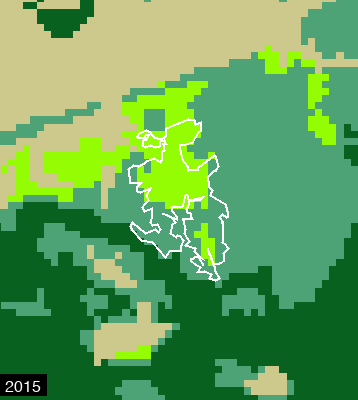

In [28]:
# Render a categorical layer
img = render_site_layer(
    site=site,
    layer=MAPBIOMAS_DEFREG,
    year=2015,
    buffer_m=500,
    dimensions=400,
    label='2015'
)

# Save single frame as PNG
img.save('../outputs/defreg_2015.png')
img

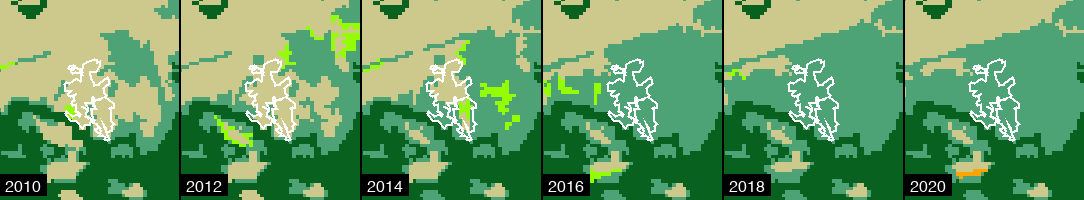

In [29]:
# Export as timestrip (PNG)
export_layer_timestrip(
    site=site,
    layer=MAPBIOMAS_DEFREG,
    output_path='../outputs/defreg_timestrip.png',
    years=[2010, 2012, 2014, 2016, 2018, 2020],
    buffer_m=500,
    tile_size=200
)

# Export as animated GIF
export_layer_gif(
    site=site,
    layer=MAPBIOMAS_DEFREG,
    output_path='../outputs/defreg_timelapse.gif',
    years=range(2010, 2021),
    buffer_m=500,
    dimensions=300,
    duration_ms=600
)

from IPython.display import Image as IPImage
IPImage('../outputs/defreg_timestrip.png')

### Using generic render_image with any ee.Image

For custom imagery or datasets not wrapped in Layer objects:

In [18]:
site = sites[0]

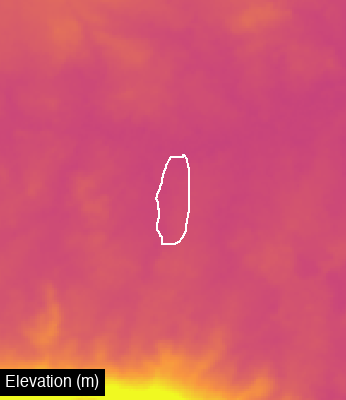

In [19]:
# Example: Render elevation data
elevation = ee.Image('USGS/SRTMGL1_003')

img = render_image(
    image=elevation,
    region=site.geometry.buffer(2000).bounds(),
    vis_params={'min': 0, 'max': 500, 'palette': ['#0d0887', '#7e03a8', '#cc4778', '#f89540', '#f0f921']},
    dimensions=400,
    boundary=site.geometry,
    label='Elevation (m)'
)
img

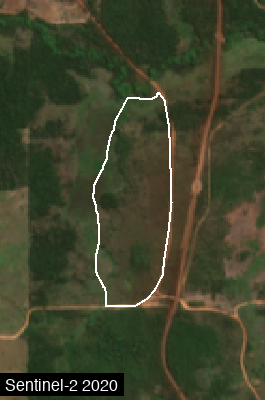

In [20]:
# Example: Sentinel-2 using the dataset helper
from gee_polygons.datasets.sentinel2 import get_sentinel_composite, SENTINEL_VIS

s2_image = get_sentinel_composite(
    geometry=site.geometry,
    date_range=('2020-06-01', '2020-08-31')
)

img = render_image(
    image=s2_image,
    region=site.geometry.buffer(500).bounds(),
    vis_params=SENTINEL_VIS,
    dimensions=400,
    boundary=site.geometry,
    label='Sentinel-2 2020'
)
img

### Sentinel-2 Timestrip (2018-2024)

Create a side-by-side comparison of dry season Sentinel-2 composites across multiple years.

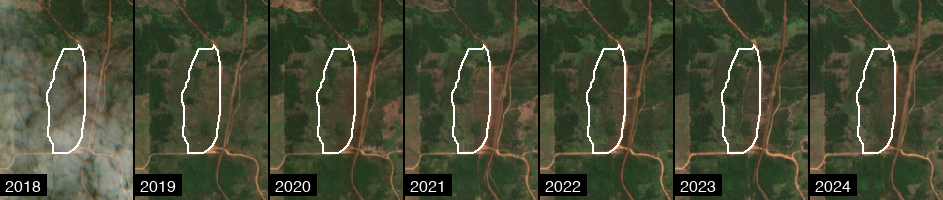

In [21]:
# Sentinel-2 timestrip: dry season composites 2018-2024
from gee_polygons.datasets.sentinel2 import get_sentinel_composite, SENTINEL_VIS

frames = []
for year in range(2018, 2025):
    # Get dry season composite (June-August)
    s2_image = get_sentinel_composite(
        geometry=site.geometry,
        date_range=(f'{year}-06-01', f'{year}-08-31'),
        cloud_pct=20
    )
    
    # Render to PIL Image with label
    frame = render_image(
        image=s2_image,
        region=site.geometry.buffer(500).bounds(),
        vis_params=SENTINEL_VIS,
        dimensions=200,
        boundary=site.geometry,
        label=str(year)
    )
    frames.append(frame)

# Export as horizontal strip
export_frames_as_strip(frames, '../outputs/sentinel_2018_2024.png')

from IPython.display import Image as IPImage
IPImage('../outputs/sentinel_2018_2024.png')

In [22]:
# Also export as animated GIF
export_frames_as_gif(frames, '../outputs/sentinel_2018_2024.gif', duration_ms=700)

Path('../outputs/sentinel_2018_2024.gif')

In [23]:
#| hide
import nbdev; nbdev.nbdev_export()